### EDA

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

INPUT_CSV = r'E:\Scaler\streamlit-insurance-premium-app\insurance.csv'      
OUT_DIR   = 'eda_plots'          
os.makedirs(OUT_DIR, exist_ok=True)
df = pd.read_csv(INPUT_CSV)

Before diving into exploratory analysis or modeling, we first confirm that our data loaded correctly and is ready to use.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


Observation:
1. 986 rows and 13 columns: a moderate‐sized dataset ideal for our tree‐based and linear models.
2. Non‐null counts show every record is present—no rows were dropped or truncated.

Next, we explicitly verify there are no missing values in any column:

In [3]:
missing_counts  = df.isnull().sum()
missing_percent = df.isnull().mean() * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPercent': missing_percent
})
print("Missing Values Summary:")
print(missing_df)

Missing Values Summary:
                         MissingCount  MissingPercent
Age                                 0             0.0
Diabetes                            0             0.0
BloodPressureProblems               0             0.0
AnyTransplants                      0             0.0
AnyChronicDiseases                  0             0.0
Height                              0             0.0
Weight                              0             0.0
KnownAllergies                      0             0.0
HistoryOfCancerInFamily             0             0.0
NumberOfMajorSurgeries              0             0.0
PremiumPrice                        0             0.0


Having confirmed data integrity, we’re now ready for our next steps: outlier detection, feature engineering, and hypothesis testing.

#### 2. Feature Engineering: Calculating BMI

One important health indicator not directly provided in the raw data is **Body Mass Index (BMI)**, which normalizes weight by height. Including BMI as a feature helps our model capture the impact of a person’s body composition on their insurance cost. High BMI is often associated with increased health risk (e.g., diabetes, hypertension) which can drive up premiums.

In [4]:
df['Height_m'] = df['Height'] / 100
df['BMI']      = df['Weight'] / (df['Height_m'] ** 2)

Let's identify extreme values that could disproportionately influence our models. We apply the Interquartile Range (IQR) rule to every numeric column

In [5]:
binary_cols = [
    'Diabetes',
    'BloodPressureProblems',
    'AnyTransplants',
    'AnyChronicDiseases',
    'KnownAllergies',
    'HistoryOfCancerInFamily'
]

numeric_cols = [
    'Age',
    'BMI',
    'NumberOfMajorSurgeries',
    'PremiumPrice'
]


# Outlier detection using IQR for all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = []
n = len(df)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    count = ((df[col] < lb) | (df[col] > ub)).sum()
    percent = (count / n) * 100
    outlier_summary.append({
        'Feature': col,
        'LowerBound': lb,
        'UpperBound': ub,
        'OutlierCount': int(count),
        'OutlierPercent': percent
    })

outlier_df = pd.DataFrame(outlier_summary).set_index('Feature')
print("\nOutlier Detection Summary (IQR Method):")
print(outlier_df)



Outlier Detection Summary (IQR Method):
                           LowerBound    UpperBound  OutlierCount  \
Feature                                                             
Age                         -4.500000     87.500000             0   
Diabetes                    -1.500000      2.500000             0   
BloodPressureProblems       -1.500000      2.500000             0   
AnyTransplants               0.000000      0.000000            55   
AnyChronicDiseases           0.000000      0.000000           178   
Height                     138.500000    198.500000             0   
Weight                      37.000000    117.000000            16   
KnownAllergies               0.000000      0.000000           212   
HistoryOfCancerInFamily      0.000000      0.000000           116   
NumberOfMajorSurgeries      -1.500000      2.500000            16   
PremiumPrice             10500.000000  38500.000000             6   
Height_m                     1.385000      1.985000           

Observation:
1. Binary flags flagged as outliers (e.g. Any Transplants, Any Chronic Diseases, Known Allergies, History Of Cancer In Family) because their IQR is zero (all values 0 or 1), every ‘1’ is marked as an outlier. We will exclude binary columns from further outlier handling and focus on continuous variables.
2. Weight: 16 points (1.62%) lie beyond [37 kg, 117 kg].
3. BMI: 22 points (2.23%) outside [12.34, 41.81].
4. NumberOfMajorSurgeries: 16 points (1.62%) at the extreme value 3.
5. PremiumPrice: 6 points (0.61%) beyond [₹10,500, ₹38,500].

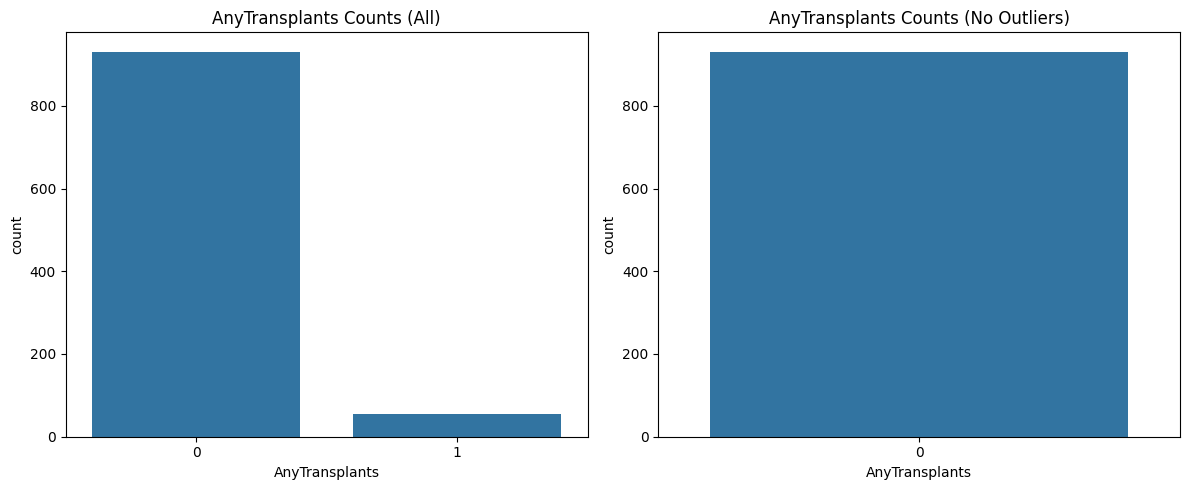

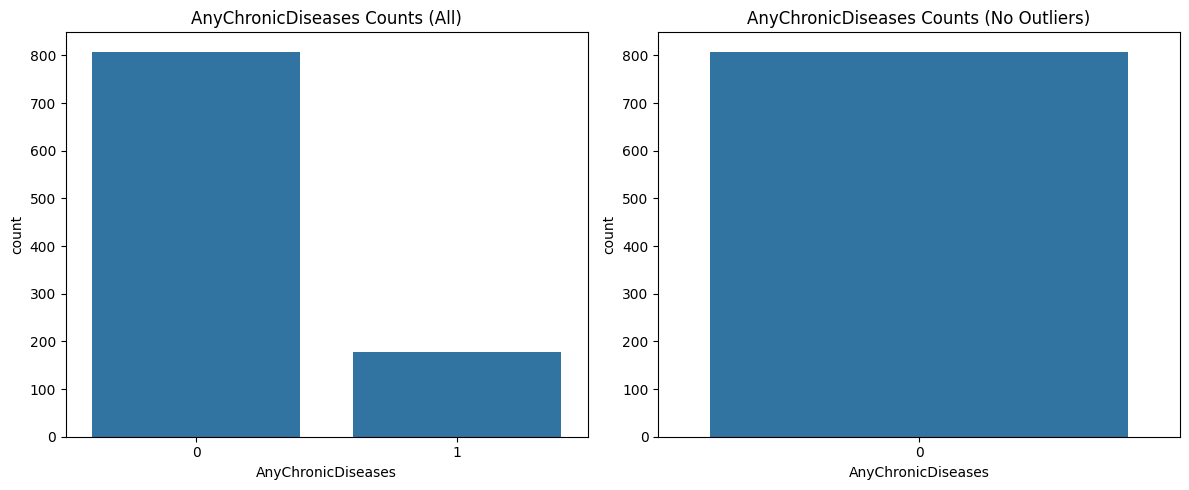

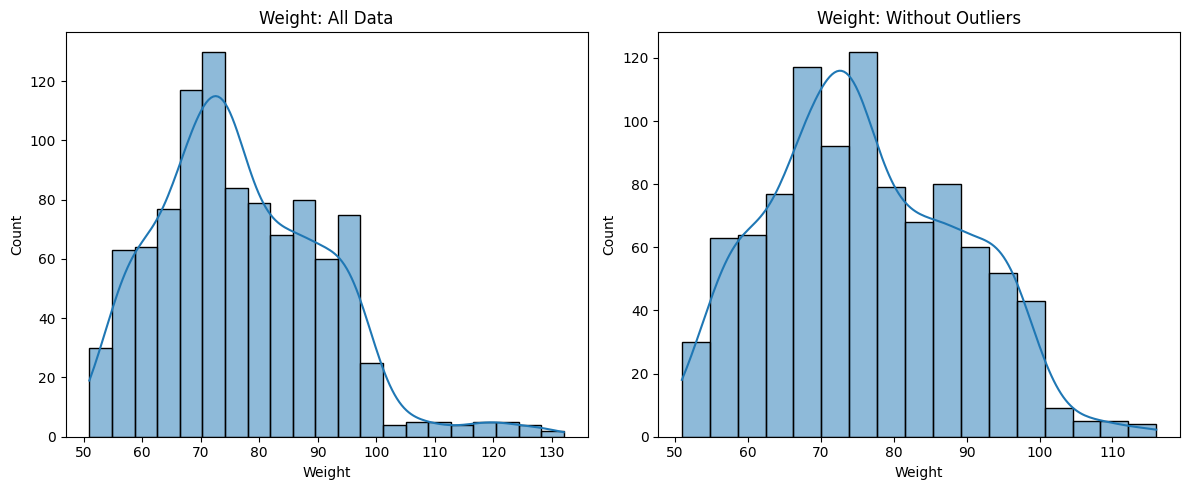

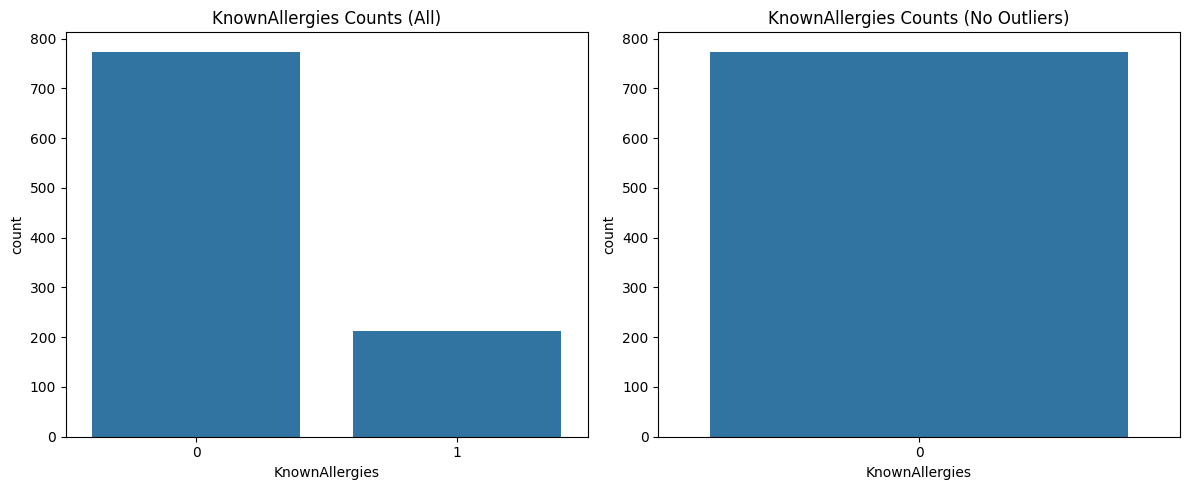

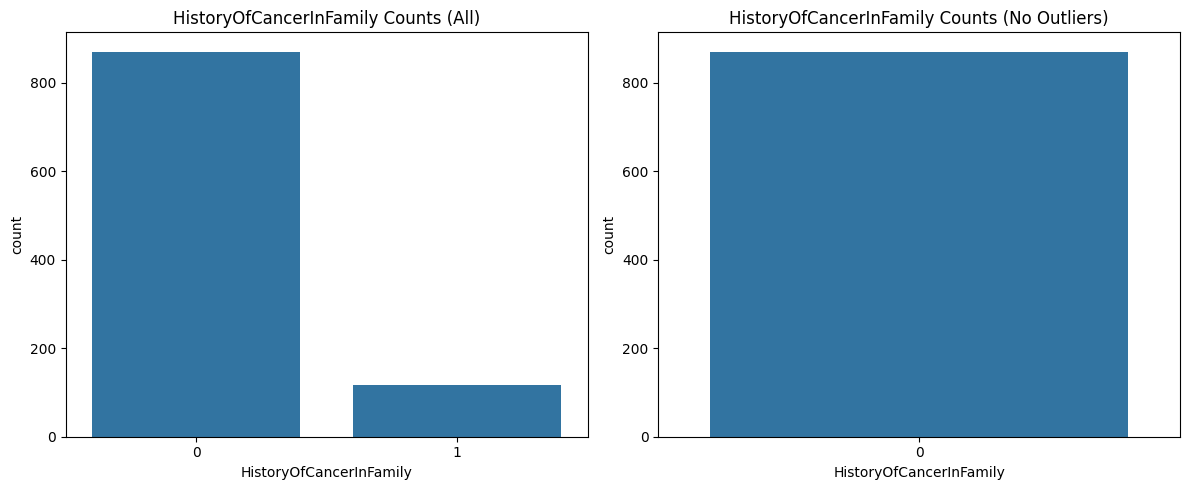

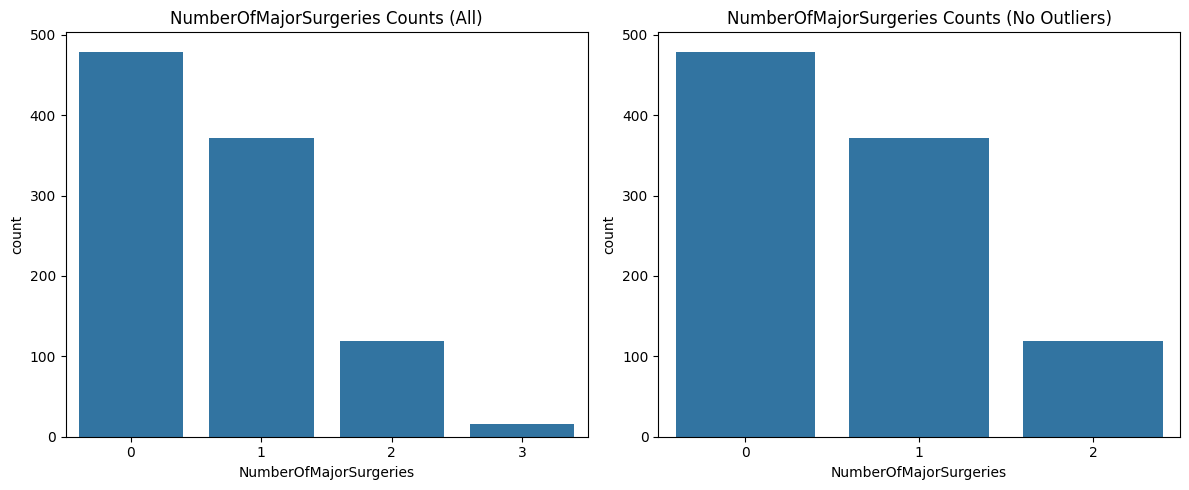

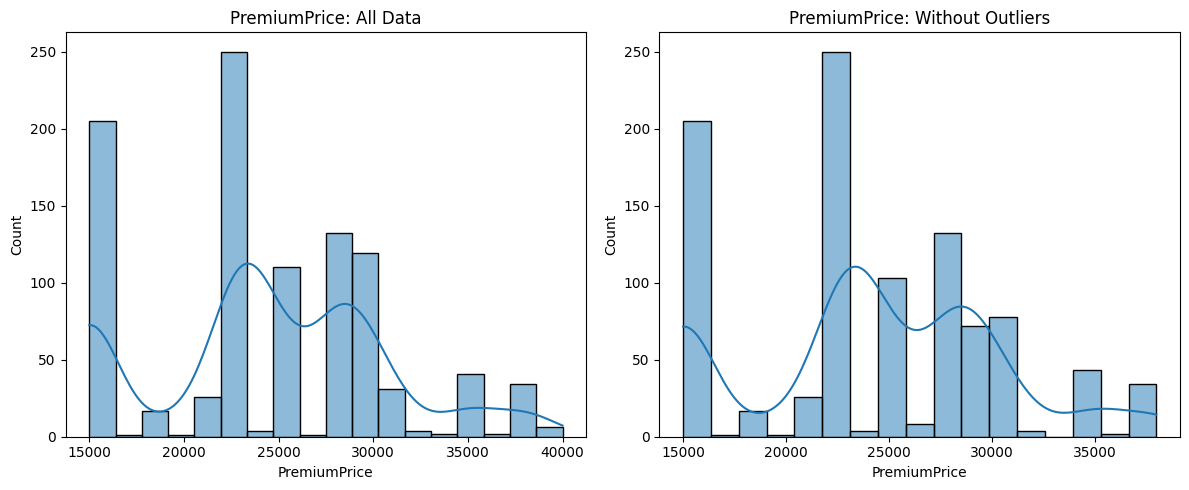

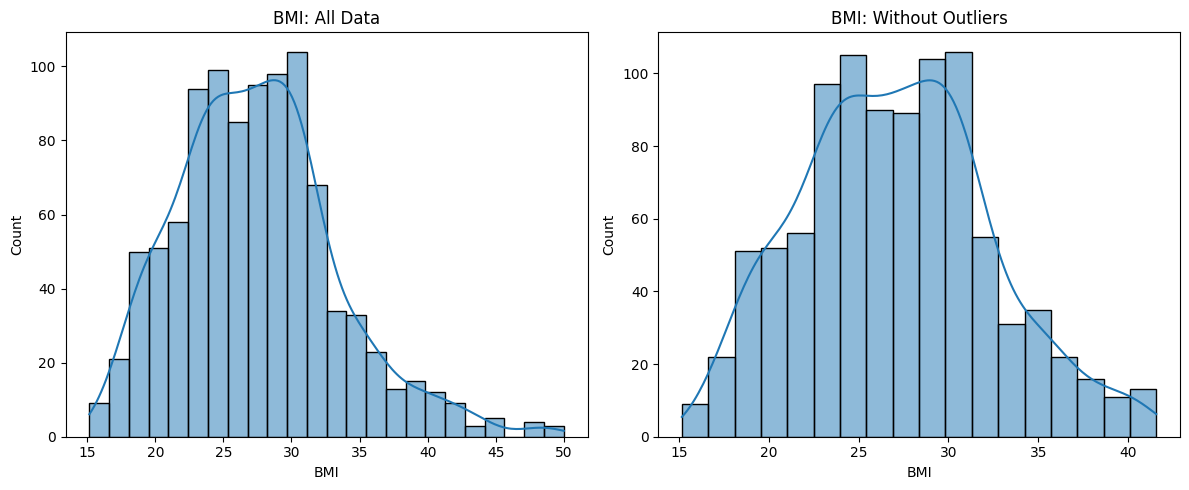

Generated before/after outlier plots for: AnyTransplants, AnyChronicDiseases, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries, PremiumPrice, BMI


In [6]:
# 3. Prepare bounds dict for features with outliers
bounds = {
    row['Feature']: (row['LowerBound'], row['UpperBound'])
    for row in outlier_summary
    if row['OutlierCount'] > 0
}

# 4. Plot before/after removal for each feature with outliers
for feature, (lb, ub) in bounds.items():
    df_no = df[(df[feature] >= lb) & (df[feature] <= ub)]

    plt.figure(figsize=(12,5))
    if df[feature].nunique() > 10:
        # Numeric distribution
        plt.subplot(1,2,1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'{feature}: All Data')
        plt.xlabel(feature)

        plt.subplot(1,2,2)
        sns.histplot(df_no[feature], kde=True)
        plt.title(f'{feature}: Without Outliers')
        plt.xlabel(feature)
    else:
        # Categorical countplot
        plt.subplot(1,2,1)
        sns.countplot(x=df[feature])
        plt.title(f'{feature} Counts (All)')
        plt.xlabel(feature)

        plt.subplot(1,2,2)
        sns.countplot(x=df_no[feature])
        plt.title(f'{feature} Counts (No Outliers)')
        plt.xlabel(feature)

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'{OUT_DIR}/{feature}_before_after_outliers.png', bbox_inches='tight')
    # plt.close()

print("Generated before/after outlier plots for:", ", ".join(bounds.keys()))


Insights:
1. BMI Distribution: About 2.2% of records beyond [12.3, 41.8] in BMI appear as extreme underweight/obese. Removing them yields a more symmetric, bell-shaped distribution, which can help regression models that assume normality.
2. PremiumPrice Skew: Very high premiums (≥₹38,500) are rare (0.6% of data). Clipping these reduces the heavy right tail, lowering variance and making error metrics (e.g. RMSE) less sensitive to a few extreme cases.
3. Weight Tail Effects: The top ~1.6% of weights above 117 kg distort the histogram’s tail. Excluding them produces a cleaner, more centralized weight distribution—beneficial for models that implicitly assume homoscedasticity.
4. The rare “3 major surgeries” cases (~1.6% of data) vanish if we blindly drop IQR outliers. These high-risk individuals are actually important for underwriting.
By visualizing before/after, we can decide to cap or transform these continuous outliers rather than drop them entirely, preserving most data while reducing undue influence from extremes.

## Univariate Analysis

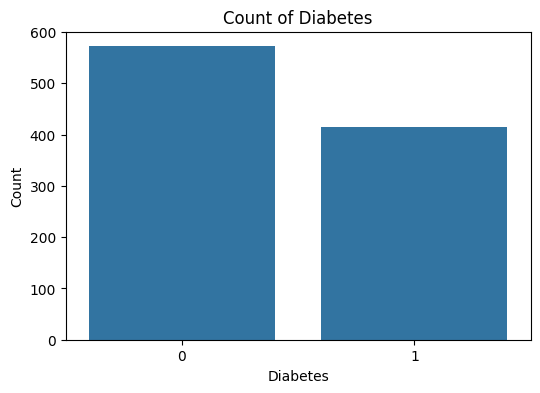

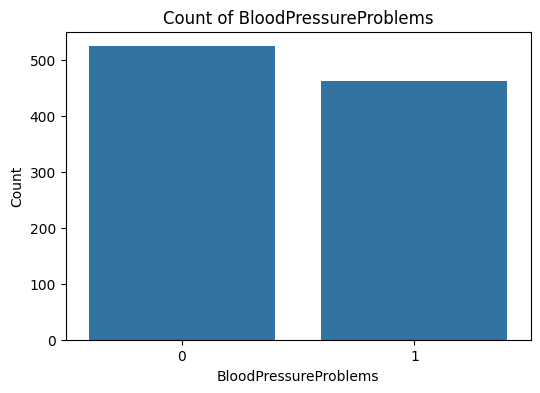

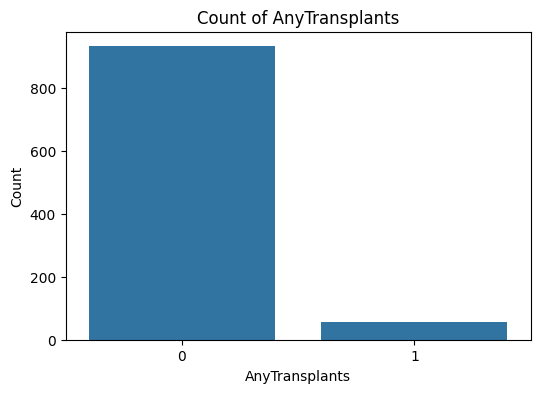

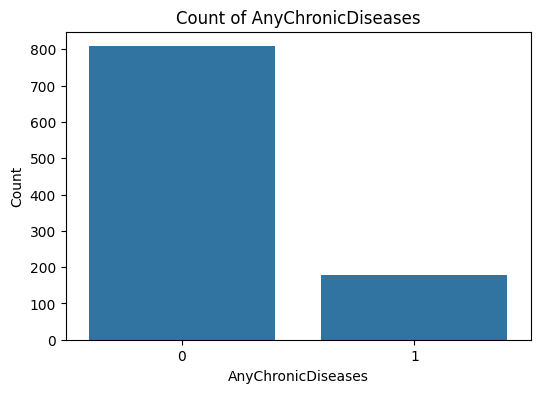

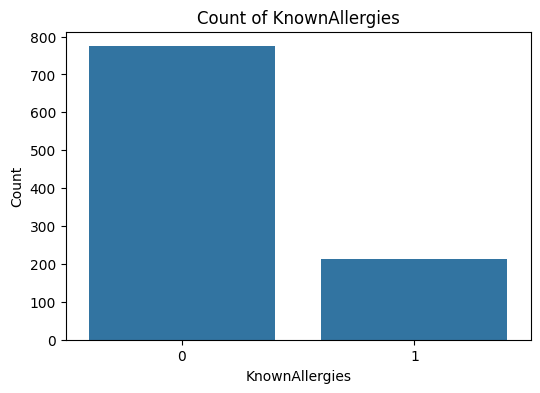

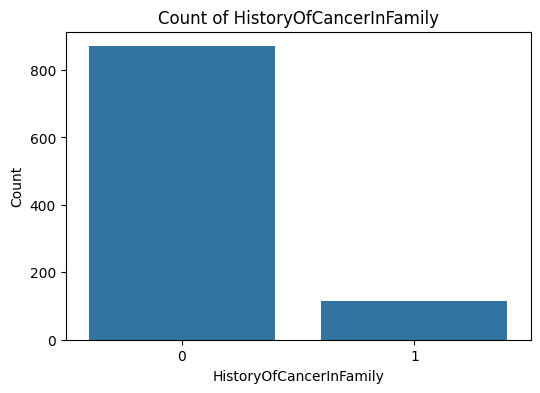

In [7]:
# Univariate Analysis: Numeric Distributions
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.savefig(f'{OUT_DIR}/{col}_distribution.png', bbox_inches='tight')
    plt.close()

# Univariate Analysis: Categorical Counts
for col in binary_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col])
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    # plt.savefig(f'{OUT_DIR}/{col}_count.png', bbox_inches='tight')
    # plt.close()
    plt.show()


Insights:
1. The age distribution is fairly uniform between 18–66, with slight peaks around the early 30s and late 40s.
2. Roughly 18 % of individuals report a chronic disease and 82 % do not. This imbalance (1 in 5 have chronic conditions) suggests the model will need to handle a minority‐class flag; it’s an important risk signal but won’t dominate the dataset.
3. Only about 5–6 % of applicants have had a transplant. This very rare event is still clinically important but must be treated carefully (e.g. as a high-impact binary indicator) rather than dropped or overly down-weighted.
4. Premiums are right-skewed: the bulk lie between ₹15 000–₹30 000, with a long tail up to ₹40 000. A log transformation or robust model (e.g. tree-based) will help mitigate that skew and reduce the influence of a few very high premiums.

## Bivariate Analysis

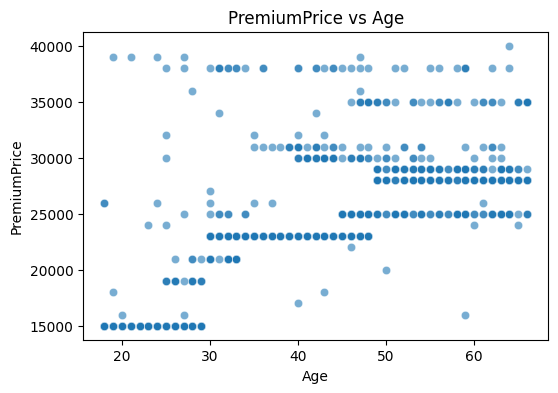

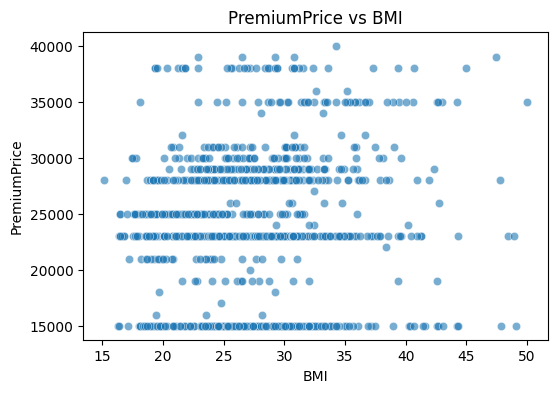

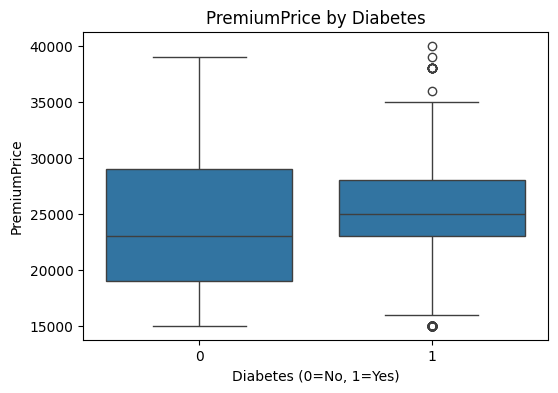

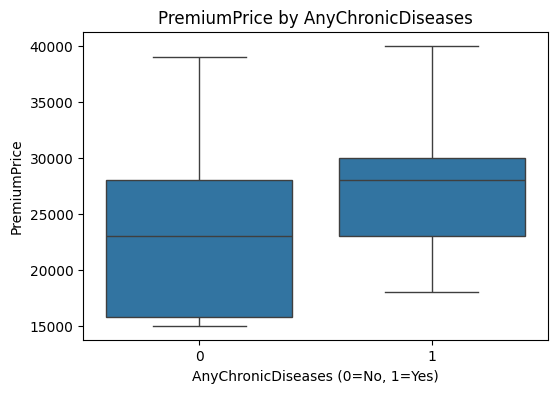

In [8]:
# Bivariate Analysis: Premium vs Age and BMI
for col in ['Age', 'BMI']:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='PremiumPrice', data=df, alpha=0.6)
    plt.title(f'PremiumPrice vs {col}')
    plt.xlabel(col)
    plt.ylabel('PremiumPrice')
    # plt.savefig(f'{OUT_DIR}/Premium_vs_{col}.png', bbox_inches='tight')
    # plt.close()
    plt.show()

# Bivariate Analysis: Boxplots by Diabetes & Chronic Disease
for col in ['Diabetes', 'AnyChronicDiseases']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], y=df['PremiumPrice'])
    plt.title(f'PremiumPrice by {col}')
    plt.xlabel(f'{col} (0=No, 1=Yes)')
    plt.ylabel('PremiumPrice')
    # plt.savefig(f'{OUT_DIR}/Boxplot_Premium_by_{col}.png', bbox_inches='tight')
    # plt.close()
    plt.show()


Insights:
1. Premium by Chronic Disease:
  Policyholders with a chronic disease (-- right box) have a higher median premium (₹28 000) than those without (₹23 000).
  Their entire IQR is shifted up by about ₹4 000–₹5 000, and the top whisker extends to ₹40 000 vs. ₹39 000 for non-chronic.
  Chronic conditions are a clear cost driver—worth treating as a prime risk flag.

2. Premium by Diabetes:
  Those with diabetes pay a slightly higher median (₹25 000) than non-diabetics (₹23 000).
  The diabetic group also shows more high-end outliers (premiums near ₹40 000), suggesting greater variability in their risk profiles.
  Diabetes has a moderate but meaningful upward effect on premiums, and introduces extra tail risk.

2. Premium vs. Age: 
  There’s a strong positive trend: younger adults (18–30) cluster around ₹15 000–₹25 000, while premiums steadily rise into the ₹25 000–₹35 000 range for ages 40–60.
  A handful of seniors (60+) hit the top end (₹35 000–₹40 000).
  Age is our single strongest continuous predictor—older age almost always means higher cost.

3. Premium vs. BMI:
  Here we see a weak, noisy upward tilt: very low BMI (< 18) and very high BMI (> 40) sometimes co-occur with higher premiums, but the cloud is broad.
  Most premiums sit between ₹20 000–₹30 000 across BMI 20–35.
  BMI by itself isn’t as powerful as Age or chronic-disease flags, but extreme BMI values do tend to be pricier.

## Multivariate Analsis

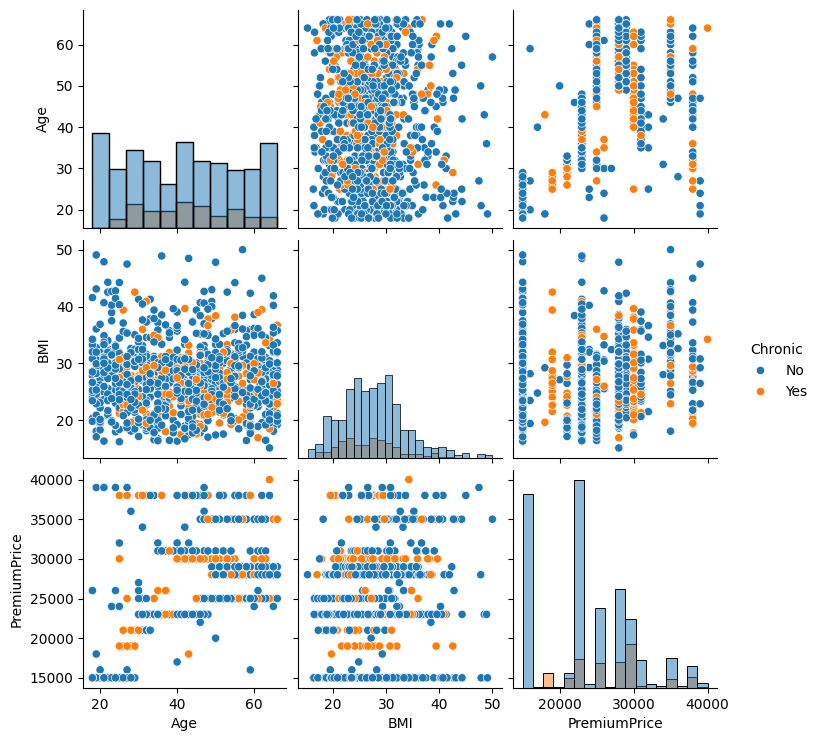

In [9]:
# Multivariate Analysis: Pairplot by Chronic Disease
df_plot = df[['Age','BMI','PremiumPrice','AnyChronicDiseases']].copy()
df_plot['Chronic'] = df_plot['AnyChronicDiseases'].map({0:'No',1:'Yes'})
pairplot = sns.pairplot(
    df_plot[['Age','BMI','PremiumPrice','Chronic']],
    hue='Chronic',
    diag_kind='hist'
)
# pairplot.savefig(f'{OUT_DIR}/pairplot.png')
# plt.close()
plt.show()

Insights:
1. Orange points (those with chronic diseases) are mostly found in the upper‐right of the PremiumPrice plots—confirming that chronic‐disease holders tend to pay higher premiums for a given age or BMI.

## Correaltion Heatmap

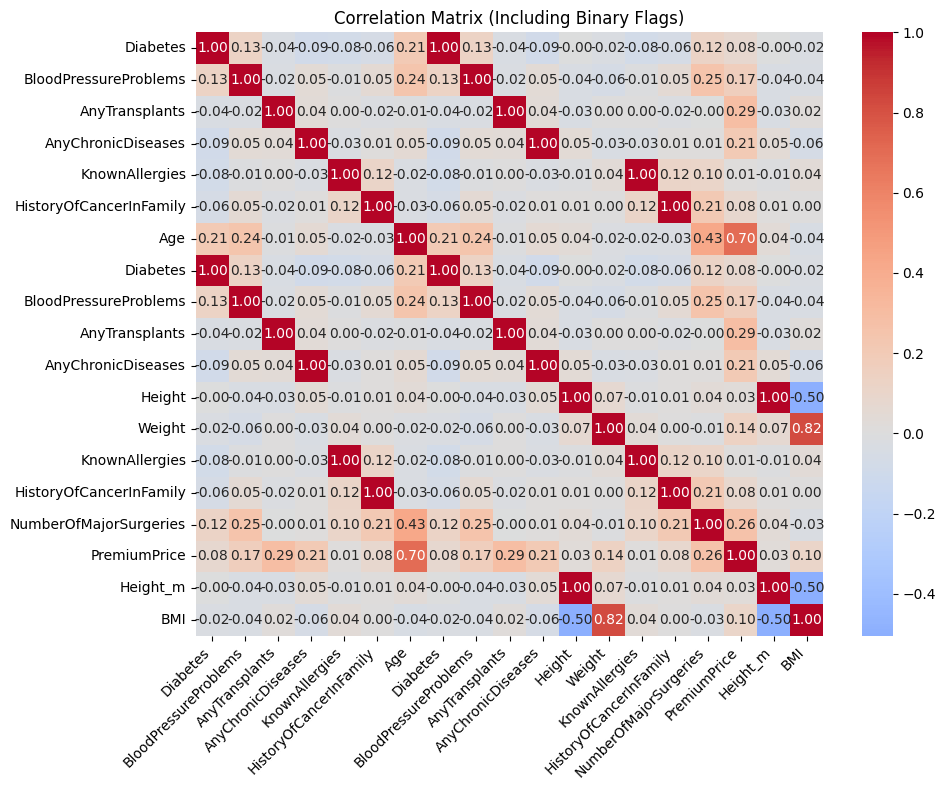

All EDA plots saved to the `eda_plots` directory.


In [10]:
# Correlation Heatmap
corr_cols = binary_cols + numeric_cols
df[binary_cols] = df[binary_cols].astype(int)
corr = df[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
    xticklabels=corr_cols, yticklabels=corr_cols
)
plt.title('Correlation Matrix (Including Binary Flags)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('eda_plots/correlation_all_features.png', bbox_inches='tight')
# plt.close()
plt.show()

print(f"All EDA plots saved to the `{OUT_DIR}` directory.")

Insights: 
1. Age (r = 0.70): By far the single strongest linear relationship. Older applicants consistently pay more, so Age should be front-and-center in any model.
2. AnyTransplants (r = 0.29): Transplant recipients incur substantially higher premiums. Even though it’s a rare flag, its presence signals major risk.
3. NumberOfMajorSurgeries (r = 0.26): Each additional surgery lifts premiums—surgeries serve as a proxy for underlying health complexity.
4. Diabetes (r = 0.08) and Family Cancer History (r = 0.08) show minimal direct correlation in isolation—these may interact with other features or be non-linear.
5. KnownAllergies and Height are essentially uncorrelated with price (|r|<0.05).
6. Age is your powerhouse predictor. Among health flags, transplants, surgery count, and chronic-disease status are the next most important

## Hypothesis Testing

##### One-sided t-test

H₀ (null): The mean premium for individuals with chronic diseases equals the mean premium for those without chronic diseases.

H₁ (alternative): The mean premium for individuals with chronic diseases is higher than for those without.

In [11]:
group_chronic    = df.loc[df['AnyChronicDiseases'] == 1, 'PremiumPrice']
group_no_chronic = df.loc[df['AnyChronicDiseases'] == 0, 'PremiumPrice']

t_stat, p_val = ttest_ind(group_chronic, group_no_chronic, equal_var=False)
print(f"Chronic vs. No Chronic: t = {t_stat:.3f}, p = {p_val:.3e}")
if p_val/2 < 0.05 and t_stat > 0:
    print("Reject H₀: premiums are significantly higher when chronic diseases are present.")
else:
    print("Fail to reject H₀.")

Chronic vs. No Chronic: t = 7.708, p = 1.728e-13
Reject H₀: premiums are significantly higher when chronic diseases are present.


In [12]:
# Perform t-tests
print("=== T-Test Results on PremiumPrice ===")
for col in binary_cols:
    group0 = df[df[col] == 0]['PremiumPrice']
    group1 = df[df[col] == 1]['PremiumPrice']
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"\n{col}:")
    print(f"  T-statistic = {t_stat:.4f}")
    print(f"  P-value     = {p_val:.6f}")
    if p_val < 0.05:
        print("  → Significant difference in PremiumPrice.")
    else:
        print("  → No significant difference.")

=== T-Test Results on PremiumPrice ===

Diabetes:
  T-statistic = -2.4489
  P-value     = 0.014508
  → Significant difference in PremiumPrice.

BloodPressureProblems:
  T-statistic = -5.3703
  P-value     = 0.000000
  → Significant difference in PremiumPrice.

AnyTransplants:
  T-statistic = -6.2599
  P-value     = 0.000000
  → Significant difference in PremiumPrice.

AnyChronicDiseases:
  T-statistic = -7.7077
  P-value     = 0.000000
  → Significant difference in PremiumPrice.

KnownAllergies:
  T-statistic = -0.3667
  P-value     = 0.714092
  → No significant difference.

HistoryOfCancerInFamily:
  T-statistic = -2.3568
  P-value     = 0.019828
  → Significant difference in PremiumPrice.


##### One-way ANOVA

H₀ (null): All group means are equal across surgery counts (0, 1, 2, 3).

H₁ (alternative): The mean premium for individuals with chronic diseases is higher than for those without.

In [13]:
surgery_groups = [
    df.loc[df['NumberOfMajorSurgeries'] == i, 'PremiumPrice']
    for i in sorted(df['NumberOfMajorSurgeries'].unique())
]

f_stat, p_val = f_oneway(*surgery_groups)
print(f"\nANOVA across surgery counts: F = {f_stat:.3f}, p = {p_val:.3e}")
if p_val < 0.05:
    print("Reject H₀: at least one surgery-count group differs in mean premium.")
else:
    print("Fail to reject H₀.")


ANOVA across surgery counts: F = 26.135, p = 2.871e-16
Reject H₀: at least one surgery-count group differs in mean premium.


#### Chi-square tests

H₀ (null): There is no association between the presence of chronic diseases and the history of cancer in the family.

H₁ (alternative): There is an association between the presence of chronic diseases and the history of cancer in the family.

In [14]:
# Create a contingency table
contingency_table = pd.crosstab(df['AnyChronicDiseases'], df['HistoryOfCancerInFamily'])

# Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("=== Chi-Square Test: Chronic Disease vs. Family History of Cancer ===")
print("Contingency Table:")
print(contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns))
print(f"\nChi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_val:.4f}")
print(f"Degrees of Freedom: {dof}")
if p_val < 0.05:
    print("Result: Reject Null Hypothesis – Significant association found.")
else:
    print("Result: Fail to Reject Null – No significant association.")

=== Chi-Square Test: Chronic Disease vs. Family History of Cancer ===
Contingency Table:
HistoryOfCancerInFamily    0   1
AnyChronicDiseases              
0                        714  94
1                        156  22

Expected Frequencies:
HistoryOfCancerInFamily           0          1
AnyChronicDiseases                            
0                        712.941176  95.058824
1                        157.058824  20.941176

Chi-Square Statistic: 0.0206
P-Value: 0.8858
Degrees of Freedom: 1
Result: Fail to Reject Null – No significant association.


In [15]:
from scipy.stats import chi2_contingency
from itertools import combinations
# Perform chi-square tests
print("\n=== Chi-Square Test Results Between Binary Variables ===")
for col1, col2 in combinations(binary_cols, 2):
    table = pd.crosstab(df[col1], df[col2])
    chi2_stat, p_val, dof, expected = chi2_contingency(table)
    print(f"\n{col1} vs {col2}:")
    print(f"  Chi-square statistic = {chi2_stat:.4f}")
    print(f"  P-value              = {p_val:.6f}")
    if p_val < 0.05:
        print("  → Significant association.")
    else:
        print("  → No significant association.")


=== Chi-Square Test Results Between Binary Variables ===

Diabetes vs BloodPressureProblems:
  Chi-square statistic = 15.5712
  P-value              = 0.000079
  → Significant association.

Diabetes vs AnyTransplants:
  Chi-square statistic = 1.0207
  P-value              = 0.312346
  → No significant association.

Diabetes vs AnyChronicDiseases:
  Chi-square statistic = 7.4214
  P-value              = 0.006445
  → Significant association.

Diabetes vs KnownAllergies:
  Chi-square statistic = 5.9377
  P-value              = 0.014821
  → Significant association.

Diabetes vs HistoryOfCancerInFamily:
  Chi-square statistic = 2.7009
  P-value              = 0.100292
  → No significant association.

BloodPressureProblems vs AnyTransplants:
  Chi-square statistic = 0.3987
  P-value              = 0.527736
  → No significant association.

BloodPressureProblems vs AnyChronicDiseases:
  Chi-square statistic = 1.8047
  P-value              = 0.179146
  → No significant association.

BloodPress

Insights:
1. T-Tests on PremiumPrice: 
    - Significant premium differences for all major health flags except KnownAllergies (p ≈ 0.71).
    - Diabetes, BP problems, transplants, chronic diseases, and family cancer history each show p < 0.05, confirming they raise mean premiums.
    - No effect from KnownAllergies, so that flag may add little predictive value in isolation.

2. Premiums vary meaningfully by the number of major surgeries (ANOVA F = 26.14, p ≈ 2.9 × 10⁻¹⁶), so surgery count should be treated as an ordinal risk factor rather than a simple binary flag.

3. Chi-Square Associations among Flags: 
    - Diabetes is significantly associated with BP problems (p ≈ 0.00008), chronic diseases (p ≈ 0.0064), and allergies (p ≈ 0.0148).
    - KnownAllergies and HistoryOfCancerInFamily are also linked (p ≈ 0.00046).
    - Most other pairs (e.g., transplants vs. chronic diseases, BP vs. allergies) show no association, indicating they capture distinct risk dimensions.

4. There is no evidence of an association between having a chronic disease and a family history of cancer (χ² = 0.02, p ≈ 0.89), indicating these two risk flags capture distinct aspects of health risk and can be modeled independently

#### Quick Regression Check

After examining each variable in isolation with t-tests and ANOVA, we turn to a multivariate Ordinary Least Squares (OLS) model to understand how our predictors work **together**. Unlike one-off tests, OLS **controls for confounding**, meaning each coefficient reflects the effect of its feature **while holding all other factors constant**. 

In [16]:
formula = 'PremiumPrice ~ Age + BMI + Diabetes + AnyChronicDiseases + NumberOfMajorSurgeries'
model  = smf.ols(formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     230.9
Date:                Sat, 17 May 2025   Prob (F-statistic):          7.08e-163
Time:                        18:26:18   Log-Likelihood:                -9632.5
No. Observations:                 986   AIC:                         1.928e+04
Df Residuals:                     980   BIC:                         1.931e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6684.7270    783.998      8.526      0.000    5146.218    8223.236
Age                      322.9993     10.922     29.572      0.000     301.565     344.433
BMI                      150.8493     23.066      6.540      0.000     105.585     196.113
Diabetes                -663.3052    281.902     -2.353      0.019   -1216.507    -110.103
AnyChronicDiseases      2852.8546    354.330      8.051      0.000    2157.521    3548.188
NumberOfMajorSurgeries  -315.7278    199.994     -1.579      0.115    -708.193      76.737
==============================================================================
Omnibus:                      366.246   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1416.557
Skew:                           1.757   Prob(JB):                    2.50e-308
Kurtosis:                       7.704   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Insights:
1. Strong drivers: Age, BMI, and chronic-disease status remain highly significant (p<0.001) with substantial effect sizes.
2. Surprising sign on Diabetes: After adjusting for age, BMI, and chronic diseases, the diabetes coefficient is negative and small (–₹663), suggesting collinearity or that diabetes risk is already captured by those other features.
3. Surgeries not significant: Once we control for age and chronic disease, the raw surgery count no longer offers clear additional predictive power (p≈0.12).
4. Model fit: R² ≈ 0.54 means these five variables explain ~54% of premium variability. There is room for non-linear effects, interactions, or additional predictors.
5. **Quantify Marginal Impact** in concrete terms—for example, the model tells us that, all else equal, each extra year of age adds about ₹323 to the premium. 
6. An R² of 0.54, OLS **assesses overall fit**, showing that these five predictors together explain roughly 54% of the variation in premiums. This combination of confounding control, precise effect sizes, and a global goodness-of-fit measure gives us a solid baseline before exploring non-linear models or interaction effects.  

### Next Steps for Model Improvement

While our baseline OLS model provides clear, interpretable coefficients, it makes strong linearity assumptions and can miss complex patterns. To build on this foundation, we will:

1. **Capture Non-linearity & Interactions**  
   Simple linear terms may not fully describe how risk factors combine. By adding polynomial terms (e.g. age²) and interaction terms (e.g. BMI × chronic disease), we can model diminishing returns or compounding effects—like whether high BMI becomes even more costly when chronic conditions are present.

2. **Transform the Target**  
   The premium distribution is right-skewed, which can violate OLS assumptions of constant variance and normal errors. Applying a log transformation to `PremiumPrice` often stabilizes variance and brings residuals closer to normality, improving both fit and inference.

3. **Regularization & Robust Regression**  
   Even after feature engineering, multicollinearity or a few extreme outliers can destabilize coefficient estimates. Techniques like Ridge or Lasso regression penalize large coefficients, while Huber regression down-weights outliers, making our model more robust and generalizable.

4. **Tree-Based Algorithms for Flexibility**  
   Methods such as Random Forests and Gradient Boosting automatically capture complex, non-linear relationships and higher-order interactions without manual specification. They also tend to be robust to outliers and collinearity.

5. **Rigorous Validation with Cross-Validation**  
   To ensure that our more sophisticated models truly generalize, we will use k-fold cross-validation. By rotating through different train/test splits, we’ll obtain reliable estimates of RMSE, MAE, and R², guard against overfitting, and compare model performance on equal footing.

By following these steps—enhancing feature richness, stabilizing variance, applying regularized and robust techniques, and validating thoroughly—we aim to surpass our current R² ≈ 0.54 benchmark and deliver a more accurate, reliable premium prediction model.  
